In [0]:
# Cell 1: Install RAG Libraries
%pip install sentence-transformers faiss-cpu gradio pandas numpy
%pip install --upgrade typing_extensions>=4.6.0
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Cell 2: Setup RAG System - Load and Embed Fraud Claims
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
import pickle
from datetime import datetime

print("Loading Gold table with fraud analysis...")
claims_gold = spark.table("fraud_detection.claims_gold").toPandas()

# Filter to suspicious claims only
suspicious_claims = claims_gold[claims_gold['final_fraud_flag'] == 1].copy()

print(f"\n✅ Loaded {len(suspicious_claims)} suspicious claims for RAG")
print(f"Date range: {suspicious_claims['claim_date'].min()} to {suspicious_claims['claim_date'].max()}")
print(f"\nSpecialties: {suspicious_claims['specialty'].value_counts().to_dict()}")

# Create rich text documents for embedding
def create_document_text(row):
    text = f"""
    Claim ID: {row['claim_id']}
    Date: {row['claim_date']}
    Specialty: {row['specialty']}
    Provider: {row['provider_name']} (ID: {row['provider_id']})
    Patient: {row['patient_name']} (ID: {row['patient_id']})
    Procedure: {row['procedure_code']}
    Diagnosis: {row['diagnosis_code']}
    Amount: ${row['billed_amount']:,.2f}
    Fraud Score: {row['fraud_score']:.2%}
    Fraud Explanation: {row['fraud_explanation']}
    Month: {row['claim_month']}
    """
    return text.strip()

suspicious_claims['document_text'] = suspicious_claims.apply(create_document_text, axis=1)

print("\n🔄 Generating embeddings with SentenceTransformer...")
# Use a lightweight but effective model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
documents = suspicious_claims['document_text'].tolist()
embeddings = embedding_model.encode(documents, show_progress_bar=True, batch_size=32)

print(f"✅ Generated {len(embeddings)} embeddings of dimension {embeddings.shape[1]}")

# Create FAISS index for fast similarity search
print("\n📊 Building FAISS vector index...")
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings.astype('float32'))

print(f"✅ FAISS index built with {index.ntotal} vectors")

# Save for reuse
print("\n💾 Caching embeddings and index...")
cache_data = {
    'embeddings': embeddings,
    'claims_data': suspicious_claims,
    'model_name': 'all-MiniLM-L6-v2'
}

# Note: In production, save to cloud storage. For hackathon, keep in memory.
print("✅ RAG system ready!")

Loading Gold table with fraud analysis...

✅ Loaded 662 suspicious claims for RAG
Date range: 2024-01-01 to 2024-12-30

Specialties: {'Orthopedics': 260, 'Neurology': 136, 'Oncology': 124, 'General Surgery': 73, 'Cardiology': 69}

🔄 Generating embeddings with SentenceTransformer...


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

✅ Generated 662 embeddings of dimension 384

📊 Building FAISS vector index...
✅ FAISS index built with 662 vectors

💾 Caching embeddings and index...
✅ RAG system ready!


In [0]:
# Cell 3: RAG Query Function
def query_fraud_claims(user_query, top_k=5):
    """
    Query the fraud claims database using natural language
    """
    # Embed the query
    query_embedding = embedding_model.encode([user_query])[0]
    
    # Search FAISS index
    distances, indices = index.search(
        query_embedding.reshape(1, -1).astype('float32'), 
        top_k
    )
    
    # Retrieve results
    results = []
    for idx, distance in zip(indices[0], distances[0]):
        claim = suspicious_claims.iloc[idx]
        results.append({
            'claim_id': claim['claim_id'],
            'date': str(claim['claim_date']),
            'specialty': claim['specialty'],
            'provider': claim['provider_name'],
            'patient': claim['patient_name'],
            'procedure': claim['procedure_code'],
            'amount': f"${claim['billed_amount']:,.2f}",
            'fraud_score': f"{claim['fraud_score']:.1%}",
            'explanation': claim['fraud_explanation'],
            'similarity_score': float(1 / (1 + distance))  # Convert distance to similarity
        })
    
    return results

# Test the query function
print("=== TESTING RAG QUERIES ===\n")

test_queries = [
    "Show me suspicious cardiology claims",
    "Find high-value fraud cases over $30,000",
    "What are the anomalies in oncology last quarter?"
]

for query in test_queries:
    print(f"Query: {query}")
    results = query_fraud_claims(query, top_k=3)
    print(f"Found {len(results)} results:\n")
    for i, result in enumerate(results, 1):
        print(f"  {i}. {result['claim_id']} - {result['specialty']} - {result['amount']}")
        print(f"     {result['explanation'][:80]}...")
    print()

=== TESTING RAG QUERIES ===

Query: Show me suspicious cardiology claims
Found 3 results:

  1. C002172 - Cardiology - $569.64
     Statistical anomaly detected | Provider has 6 known fraud cases...
  2. C003394 - Cardiology - $825.29
     Statistical anomaly detected | Provider has 6 known fraud cases...
  3. C004375 - Cardiology - $353.51
     Statistical anomaly detected | Provider has 6 known fraud cases...

Query: Find high-value fraud cases over $30,000
Found 3 results:

  1. C004609 - Neurology - $19,528.14
     Known fraud: Amount 19528 is 3-5x normal range | ML detected (confidence: 97.67%...
  2. C004969 - Orthopedics - $2,899.69
     Known fraud: Orthopedics provider performing Neurology procedure | ML detected (...
  3. C004884 - Neurology - $21,603.75
     Known fraud: Amount 21604 is 3-5x normal range | ML detected (confidence: 99.71%...

Query: What are the anomalies in oncology last quarter?
Found 3 results:

  1. C004593 - Oncology - $10,044.56
     Statistical anomaly

In [0]:
# Cell 4: Simple Interactive Demo (Works in Databricks)
import pandas as pd

def display_fraud_results(query, top_k=5):
    """Display fraud search results in notebook"""
    results = query_fraud_claims(query, top_k=top_k)
    
    total_amount = sum([float(r['amount'].replace('$', '').replace(',', '')) for r in results])
    specialties = list(set([r['specialty'] for r in results]))
    
    print(f"\n{'='*80}")
    print(f"🔍 QUERY: {query}")
    print(f"{'='*80}")
    print(f"\n📊 SUMMARY:")
    print(f"   • Results Found: {len(results)} suspicious claims")
    print(f"   • Total Amount: ${total_amount:,.2f}")
    print(f"   • Specialties: {', '.join(specialties)}")
    print(f"\n📋 DETAILED RESULTS:\n")
    
    for i, result in enumerate(results, 1):
        print(f"   {i}. 🚨 CLAIM ID: {result['claim_id']}")
        print(f"      └─ Date: {result['date']}")
        print(f"      └─ Specialty: {result['specialty']}")
        print(f"      └─ Provider: {result['provider']}")
        print(f"      └─ Patient: {result['patient']}")
        print(f"      └─ Procedure: {result['procedure']}")
        print(f"      └─ Billed Amount: {result['amount']} 💰")
        print(f"      └─ Fraud Score: {result['fraud_score']} ⚠️")
        print(f"      └─ Relevance: {result['similarity_score']:.1%} 🎯")
        print(f"      └─ 🔍 Why Flagged: {result['explanation']}")
        print()
    
    print(f"{'='*80}\n")
    
    return pd.DataFrame(results)

# Demo Queries
print("\n" + "🏥 HEALTHCARE FRAUD DETECTION - RAG CHATBOT DEMO".center(80, "="))
print(f"\nTotal Suspicious Claims in Database: {len(suspicious_claims)}")
print(f"Date Range: {suspicious_claims['claim_date'].min()} to {suspicious_claims['claim_date'].max()}")
print(f"Specialties Available: {', '.join(suspicious_claims['specialty'].unique())}")

# Execute demo queries
demo_queries = [
    "Show me suspicious cardiology claims with high amounts",
    "Find duplicate billing fraud cases",
    "What are high-value anomalies over $30,000?",
    "Show me procedure mismatch fraud in oncology",
    "Find orthopedics claims with abnormal pricing"
]

print(f"\n{'='*80}")
print("RUNNING 5 DEMO QUERIES TO SHOWCASE RAG CAPABILITIES")
print(f"{'='*80}\n")

for query in demo_queries:
    df_results = display_fraud_results(query, top_k=3)


================🏥 HEALTHCARE FRAUD DETECTION - RAG CHATBOT DEMO=================

Total Suspicious Claims in Database: 662
Date Range: 2024-01-01 to 2024-12-30
Specialties Available: Orthopedics, Cardiology, Oncology, Neurology, General Surgery

RUNNING 5 DEMO QUERIES TO SHOWCASE RAG CAPABILITIES


🔍 QUERY: Show me suspicious cardiology claims with high amounts

📊 SUMMARY:
   • Results Found: 3 suspicious claims
   • Total Amount: $1,717.60
   • Specialties: Cardiology

📋 DETAILED RESULTS:

   1. 🚨 CLAIM ID: C002172
      └─ Date: 2024-09-15
      └─ Specialty: Cardiology
      └─ Provider: Dr. Jones
      └─ Patient: Christopher Walton MD
      └─ Procedure: Stress Test
      └─ Billed Amount: $569.64 💰
      └─ Fraud Score: 19.8% ⚠️
      └─ Relevance: 61.3% 🎯
      └─ 🔍 Why Flagged: Statistical anomaly detected | Provider has 6 known fraud cases

   2. 🚨 CLAIM ID: C004375
      └─ Date: 2024-01-14
      └─ Specialty: Cardiology
      └─ Provider: Dr. Jones
      └─ Patient: Jason M

📊 GENERATING FRAUD ANALYTICS DASHBOARD...



/home/spark-53156cb4-30b9-425f-8737-2c/.ipykernel/4745/command-4943106047869771-617515347:42: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


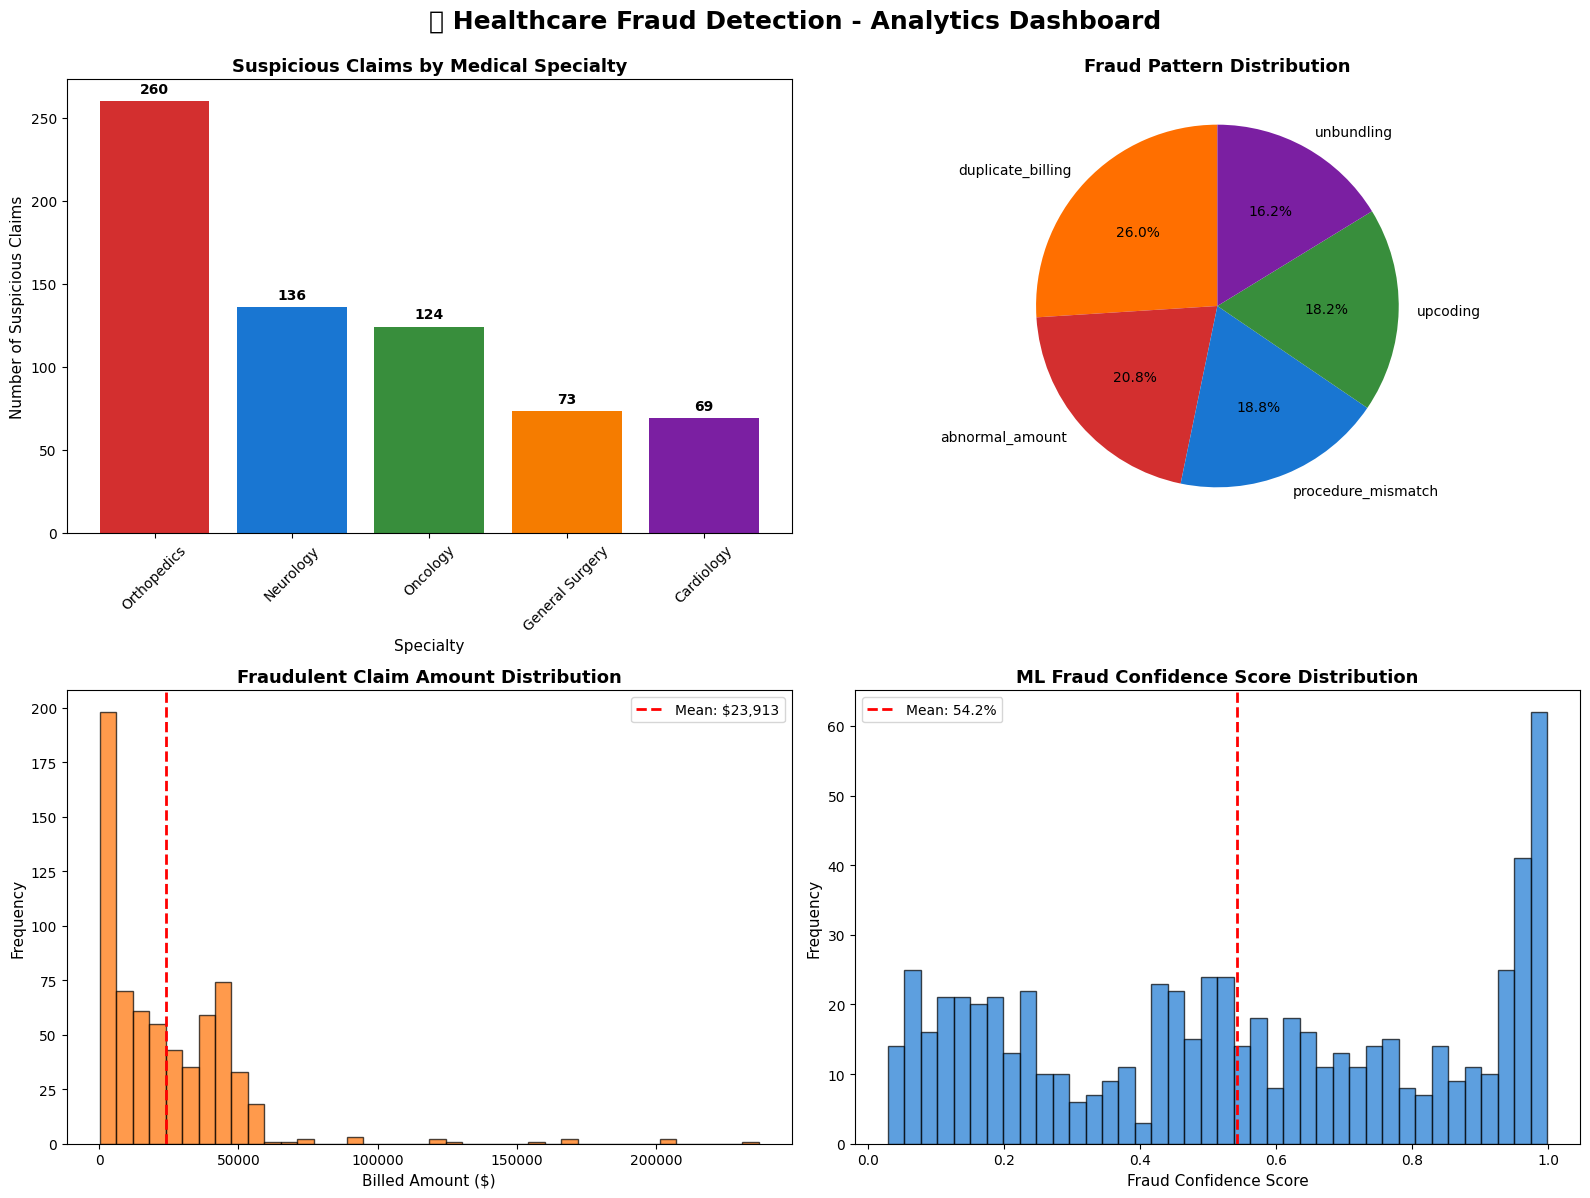


                        📊 FRAUD DETECTION IMPACT SUMMARY                        

Metric                                                            Value
--------------------------------------------------------------------------------
Total Suspicious Claims Detected                                    662
Total Fraudulent Amount Flagged                          $15,830,598.99
Average Claim Amount                                         $23,913.29
Average ML Fraud Confidence                                       54.2%
Most Problematic Specialty                                  Orthopedics


In [0]:
# Cell 6: Visual Analytics Dashboard
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 GENERATING FRAUD ANALYTICS DASHBOARD...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🏥 Healthcare Fraud Detection - Analytics Dashboard', fontsize=18, fontweight='bold', y=0.995)

# 1. Fraud by Specialty
specialty_counts = suspicious_claims['specialty'].value_counts()
axes[0, 0].bar(specialty_counts.index, specialty_counts.values, color=['#d32f2f', '#1976d2', '#388e3c', '#f57c00', '#7b1fa2'])
axes[0, 0].set_title('Suspicious Claims by Medical Specialty', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Specialty', fontsize=11)
axes[0, 0].set_ylabel('Number of Suspicious Claims', fontsize=11)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(specialty_counts.values):
    axes[0, 0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# 2. Fraud Type Distribution
fraud_types = suspicious_claims[suspicious_claims['fraud_type'].notna()]['fraud_type'].value_counts()
colors = ['#ff6f00', '#d32f2f', '#1976d2', '#388e3c', '#7b1fa2']
axes[0, 1].pie(fraud_types.values, labels=fraud_types.index, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0, 1].set_title('Fraud Pattern Distribution', fontsize=13, fontweight='bold')

# 3. Amount Distribution
axes[1, 0].hist(suspicious_claims['billed_amount'], bins=40, color='#ff6f00', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(suspicious_claims['billed_amount'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${suspicious_claims["billed_amount"].mean():,.0f}')
axes[1, 0].set_title('Fraudulent Claim Amount Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Billed Amount ($)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].legend()

# 4. Fraud Score Distribution  
axes[1, 1].hist(suspicious_claims['fraud_score'], bins=40, color='#1976d2', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(suspicious_claims['fraud_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {suspicious_claims["fraud_score"].mean():.1%}')
axes[1, 1].set_title('ML Fraud Confidence Score Distribution', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Fraud Confidence Score', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n" + "="*80)
print("📊 FRAUD DETECTION IMPACT SUMMARY".center(80))
print("="*80)
print(f"\n{'Metric':<45} {'Value':>25}")
print("-"*80)
print(f"{'Total Suspicious Claims Detected':<45} {len(suspicious_claims):>25,}")
print(f"{'Total Fraudulent Amount Flagged':<45} {'$' + f'{suspicious_claims["billed_amount"].sum():,.2f}':>25}")
print(f"{'Average Claim Amount':<45} {'$' + f'{suspicious_claims["billed_amount"].mean():,.2f}':>25}")
print(f"{'Average ML Fraud Confidence':<45} {f'{suspicious_claims["fraud_score"].mean():.1%}':>25}")
print(f"{'Most Problematic Specialty':<45} {specialty_counts.index[0]:>25}")
print("="*80)